# Training ResNet on CIFAR-10
The improved training pipeline for SimpleNN developed in Lab (2) still has limited performance. This is
mainly because the SimpleNN has rather small capacity (learning capability) for CIFAR-10 task. Thus,
in this lab we replace the SimpleNN model with a more advanced ResNet [3] architecture. We expect
to see much higher accuracy on CIFAR-10 when using ResNets. Here, you may duplicate your jupyter
notebook for Lab (2) as resnet-cifar10.ipynb to serve as a starting point.

### Question (a) (8 pts) 

Implement the ResNet-20 architecture by following Section 4.2 of the ResNet paper [3]. This
lab is designed to have you learn how to implement a DNN model yourself, so do NOT borrow any
code from online resource.

In [9]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Define plotting parameters
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

In [2]:
# define the ResNet model;
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        
        # First layer of 3x3 conv
        self.conv1 = nn.Conv2d(3, 16, 3, padding = "same")
        
        # Next six layers of 3x3 conv with 32x32 output maps
        self.conv2 = nn.Conv2d(16, 16, 3, padding = "same")
        self.conv3 = nn.Conv2d(16, 16, 3, padding = "same") # shortcut
        self.conv4 = nn.Conv2d(16, 16, 3, padding = "same")
        self.conv5 = nn.Conv2d(16, 16, 3, padding = "same") # shortcut
        self.conv6 = nn.Conv2d(16, 16, 3, padding = "same")
        self.conv7 = nn.Conv2d(16, 16, 3, padding = "same") # shortcut
        
        # Next six layers of 3x3 conv with 16x16 output maps
        self.conv8 = nn.Conv2d(16, 32, 3, padding = (1,1), stride = 2)
        self.conv9 = nn.Conv2d(32, 32, 3, padding = "same") # shortcut
        self.conv10 = nn.Conv2d(32, 32, 3, padding = "same")
        self.conv11 = nn.Conv2d(32, 32, 3, padding = "same") # shortcut
        self.conv12 = nn.Conv2d(32, 32, 3, padding = "same")
        self.conv13 = nn.Conv2d(32, 32, 3, padding = "same") # shortcut
        
        # Next six layers of 3x3 conv with 8x8 output maps
        self.conv14 = nn.Conv2d(32, 64, 3, padding = (1,1), stride = 2)
        self.conv15 = nn.Conv2d(64, 64, 3, padding = "same") # shortcut
        self.conv16 = nn.Conv2d(64, 64, 3, padding = "same")
        self.conv17 = nn.Conv2d(64, 64, 3, padding = "same") # shortcut
        self.conv18 = nn.Conv2d(64, 64, 3, padding = "same")
        self.conv19 = nn.Conv2d(64, 64, 3, padding = "same") # shortcut
        
        # Fully connected layers
        self.fc = nn.Linear(64,10)
        
        # Batch Normalization Layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm2d(16)
        self.bn5 = nn.BatchNorm2d(16)
        self.bn6 = nn.BatchNorm2d(16)
        self.bn7 = nn.BatchNorm2d(16)
        self.bn8 = nn.BatchNorm2d(32)
        self.bn9 = nn.BatchNorm2d(32)
        self.bn10 = nn.BatchNorm2d(32)
        self.bn11 = nn.BatchNorm2d(32)
        self.bn12 = nn.BatchNorm2d(32)
        self.bn13 = nn.BatchNorm2d(32)
        self.bn14 = nn.BatchNorm2d(64)
        self.bn15 = nn.BatchNorm2d(64)
        self.bn16 = nn.BatchNorm2d(64)
        self.bn17 = nn.BatchNorm2d(64)
        self.bn18 = nn.BatchNorm2d(64)
        self.bn19 = nn.BatchNorm2d(64)

    def forward(self, x):
        # First convolution layer
        out_sc1 = F.relu(self.bn1(self.conv1(x)))
        
        # Next 6 with 32x32 maps, 16 filters
        out = F.relu(self.bn2(self.conv2(out_sc1)))
        out_sc2 = F.relu(self.bn3(self.conv3(out)) + out_sc1)
        out = F.relu(self.bn4(self.conv4(out_sc2)))
        out_sc3 = F.relu(self.bn5(self.conv5(out)) + out_sc2)
        out = F.relu(self.bn6(self.conv6(out_sc3)))
        out_sc4 = F.relu(self.bn7(self.conv7(out)) + out_sc3)
        
        # Next 6 with 16x16 maps, 32 filters
        out = F.relu(self.bn8(self.conv8(out_sc4)))
        out_sc4 = F.avg_pool2d(out_sc4, 2)
        out_sc4 = F.pad(out_sc4, (0, 0, 0, 0, 0, 16))
        out_sc5 = F.relu(self.bn9(self.conv9(out)) + out_sc4)
        out = F.relu(self.bn10(self.conv10(out_sc5)))
        out_sc6 = F.relu(self.bn11(self.conv11(out)) + out_sc5)
        out = F.relu(self.bn12(self.conv12(out_sc6)))
        out_sc7 = F.relu(self.bn13(self.conv13(out)) + out_sc6)
        
        # Next 6 with 8x8 maps, 64 filters
        out = F.relu(self.bn14(self.conv14(out_sc7)))
        out_sc7 = F.avg_pool2d(out_sc7, 2)
        out_sc7 = F.pad(out_sc7, (0, 0, 0, 0, 0, 32))
        out_sc8 = F.relu(self.bn15(self.conv15(out)) + out_sc7)
        out = F.relu(self.bn16(self.conv16(out_sc8)))
        out_sc9 = F.relu(self.bn17(self.conv17(out)) + out_sc8)
        out = F.relu(self.bn18(self.conv18(out_sc9)))
        out = F.relu(self.bn19(self.conv19(out)) + out_sc9)
        
        # Average pooling to get size 64 tensors
        out = F.avg_pool2d(out, 8)
        # Flatten the output tensor
        out = out.view(out.size(0), -1)
        # Fully-Connected Layer
        out = self.fc(out)
        return out

In [ ]:
## define the ResNet model;
# class ResNet(nn.Module):
#     def __init__(self):
#         super(ResNet, self).__init__()
        
#         # First layer of 3x3 conv
#         self.conv1 = nn.Conv2d(3, 16, 3, padding = "same")
        
#         # Next six layers of 3x3 conv with 32x32 output maps
#         self.conv2 = nn.Conv2d(16, 16, 3, padding = "same")
#         self.conv3 = nn.Conv2d(16, 16, 3, padding = "same") # shortcut
#         self.conv4 = nn.Conv2d(16, 16, 3, padding = "same")
#         self.conv5 = nn.Conv2d(16, 16, 3, padding = "same") # shortcut
#         self.conv6 = nn.Conv2d(16, 16, 3, padding = "same")
#         self.conv7 = nn.Conv2d(16, 16, 3, padding = "same") # shortcut
        
#         # Next six layers of 3x3 conv with 16x16 output maps
#         self.conv8 = nn.Conv2d(16, 32, 3, padding = (1,1), stride = 2)
#         self.conv9 = nn.Conv2d(32, 32, 3, padding = "same") # shortcut
#         self.conv10 = nn.Conv2d(32, 32, 3, padding = "same")
#         self.conv11 = nn.Conv2d(32, 32, 3, padding = "same") # shortcut
#         self.conv12 = nn.Conv2d(32, 32, 3, padding = "same")
#         self.conv13 = nn.Conv2d(32, 32, 3, padding = "same") # shortcut
        
#         # Next six layers of 3x3 conv with 8x8 output maps
#         self.conv14 = nn.Conv2d(32, 64, 3, padding = (1,1), stride = 2)
#         self.conv15 = nn.Conv2d(64, 64, 3, padding = "same") # shortcut
#         self.conv16 = nn.Conv2d(64, 64, 3, padding = "same")
#         self.conv17 = nn.Conv2d(64, 64, 3, padding = "same") # shortcut
#         self.conv18 = nn.Conv2d(64, 64, 3, padding = "same")
#         self.conv19 = nn.Conv2d(64, 64, 3, padding = "same") # shortcut

#         # Convolution for filter-size conversions
#         self.conv_sc4 = nn.Conv2d(16, 32, kernel_size=1, stride = 2, padding = "same")
#         self.conv_sc7 = nn.Conv2d(32, 64, kernel_size=1, stride = 2, padding = "same")
        
#         # Fully connected layers
#         self.fc = nn.Linear(64,10)
        
#         # Batch Normalization Layers
#         self.bn1 = nn.BatchNorm2d(16)
#         self.bn2 = nn.BatchNorm2d(16)
#         self.bn3 = nn.BatchNorm2d(16)
#         self.bn4 = nn.BatchNorm2d(16)
#         self.bn5 = nn.BatchNorm2d(16)
#         self.bn6 = nn.BatchNorm2d(16)
#         self.bn7 = nn.BatchNorm2d(16)
#         self.bn8 = nn.BatchNorm2d(32)
#         self.bn9 = nn.BatchNorm2d(32)
#         self.bn10 = nn.BatchNorm2d(32)
#         self.bn11 = nn.BatchNorm2d(32)
#         self.bn12 = nn.BatchNorm2d(32)
#         self.bn13 = nn.BatchNorm2d(32)
#         self.bn14 = nn.BatchNorm2d(64)
#         self.bn15 = nn.BatchNorm2d(64)
#         self.bn16 = nn.BatchNorm2d(64)
#         self.bn17 = nn.BatchNorm2d(64)
#         self.bn18 = nn.BatchNorm2d(64)
#         self.bn19 = nn.BatchNorm2d(64)

#         # Batch normalization for filter-size conversions
#         self.bn_sc4 = nn.BatchNorm2d(32)
#         self.bn_sc7 = nn.BatchNorm2d(64)

#     def forward(self, x):
#         # First convolution layer
#         out_sc1 = F.relu(self.bn1(self.conv1(x)))
        
#         # Next 6 with 32x32 maps, 16 filters
#         out = F.relu(self.bn2(self.conv2(out_sc1)))
#         out_sc2 = F.relu(self.bn3(self.conv3(out)) + out_sc1)
#         out = F.relu(self.bn4(self.conv4(out_sc2)))
#         out_sc3 = F.relu(self.bn5(self.conv5(out)) + out_sc2)
#         out = F.relu(self.bn6(self.conv6(out_sc3)))
#         out_sc4 = F.relu(self.bn7(self.conv7(out)) + out_sc3)
        
#         # Next 6 with 16x16 maps, 32 filters
#         out = F.relu(self.bn8(self.conv8(out_sc4)))
#         out_sc4 = F.relu(self.bn_sc4(self.conv_sc4(out_sc4)))
#         out_sc5 = F.relu(self.bn9(self.conv9(out)) + out_sc4)
#         out = F.relu(self.bn10(self.conv10(out_sc5)))
#         out_sc6 = F.relu(self.bn11(self.conv11(out)) + out_sc5)
#         out = F.relu(self.bn12(self.conv12(out_sc6)))
#         out_sc7 = F.relu(self.bn13(self.conv13(out)) + out_sc6)
        
#         # Next 6 with 8x8 maps, 64 filters
#         out = F.relu(self.bn14(self.conv14(out_sc7)))
#         out_sc7 = F.relu(self.bn_sc7(self.conv_sc7(out_sc7)))
#         out_sc8 = F.relu(self.bn15(self.conv15(out)) + out_sc7)
#         out = F.relu(self.bn16(self.conv16(out_sc8)))
#         out_sc9 = F.relu(self.bn17(self.conv17(out)) + out_sc8)
#         out = F.relu(self.bn18(self.conv18(out_sc9)))
#         out = F.relu(self.bn19(self.conv19(out)) + out_sc9)
        
#         # Average pooling to get size 64 tensors
#         out = F.avg_pool2d(out, 8)
#         # Flatten the output tensor
#         out = out.view(out.size(0), -1)
#         # Fully-Connected Layer
#         out = self.fc(out)
#         return out

### Question (a)
Here is a sanity check to verify the implementation of SimpleNN.
You need to:
1. Write down your code.
2. **In the PDF report**, give a brief description on how the code helps you know that SimpleNN is implemented correctly.

In [3]:
#############################################
# your code here
# sanity check for the correctness of SimpleNN

## Create random data to pass through the SimpleNN architecture
random_data = torch.randn(1,3,32,32)
## Create an example network to test on
test_network = ResNet()
## Feed the sample data into the network to get test result
test_out = test_network(random_data)
## Check to make sure that the output has shape 1x10
assert(test_out.detach().cpu().numpy().shape == (1,10))
print("Forward pass successful")

# ## Count the number of parameters in each layer
# for name, parameters in test_network.named_parameters():
#   ## Print the shape of the parameter vector for each layer
#   print(f'{name:10}: {str(parameters.shape):10}')
# #############################################

Forward pass successful


> Here, I used one batch of random data in the format of 3 layers (RBG) each having 32x32 pixels to pass through the constructed SimpleNN structure. To verify that the pass was successful, I checked to make sure that the output has is in shape 1x10.
>
> And to verify the structure of the layers, I checked the shape of the parameters in the network to make sure they align with my expectations of what was inputted in the SimpleNN structure.

## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (b)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint:
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [4]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomCrop(size = 32, padding = 4),
    transforms.RandomHorizontalFlip()]
    )
transform_val = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
    )
#############################################

> In this operation I used random to crop out 7 pixels from the center and then random horizontal flips with a probability of 0.5.

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [5]:
# Unzip the tools zipfile
# !unzip tools.zip

Archive:  tools.zip
replace tools/utils.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT,
    mode='train',
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT,
    mode='val',
    download=True,
    transform=transform_val    # your code
)

# construct dataloader
train_loader = DataLoader(
    train_set,
    batch_size=TRAIN_BATCH_SIZE,  # your code
    shuffle=True,     # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle=False,     # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [6]:
# specify the device for computation
#############################################
# your code here

# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")
#############################################


Run on GPU...


## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum.

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [14]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-3

#############################################
# your code here
model = ResNet()
model.to(device)
# create loss function
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(model.parameters(), lr = INITIAL_LR, momentum = MOMENTUM, weight_decay = REG)
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps:

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities?)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


# Bonus: with learning rate decay

The following code can help you adjust the learning rate during training. You need to figure out how to incorporate this code into your training loop.
```python
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
```

In [8]:
# total number of training epochs
EPOCHS = 200
# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model_resnet"
## Set the scaler for the decay
DECAY = 0.1

## Define training function to train the model
def train_model(
    model, EPOCHS, 
    CHECKPOINT_FOLDER, INITIAL_LR, 
    DECAY_EPOCHS = None, DECAY = None, 
    TRACK = False,
    VERBOSE = False):
    # some hyperparameters
    # start the training/validation process
    # the process should take about 5 minutes on a GTX 1070-Ti
    # if the code is written efficiently.
    best_val_acc = 0
    current_learning_rate = INITIAL_LR
    if VERBOSE:
        print("==> Training starts!")
        print("="*50)
    #Initiate training loss and validation loss trackers
    train_tracker = []
    val_tracker = []
    train_acc = []
    val_acc = []
        
    for i in range(0, EPOCHS):
        # handle the learning rate scheduler.
        if DECAY_EPOCHS is not None and i % DECAY_EPOCHS == 0 and i != 0 and DECAY is not None:
            current_learning_rate = current_learning_rate * DECAY
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_learning_rate
            if VERBOSE:
                print("Current learning rate has decayed to %f" %current_learning_rate)

        #######################
        # your code here
        # switch to train mode
        model.train()

        #######################
        if VERBOSE:
            print("Epoch %d:" %i)
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0
        
        train_loss = 0 # track training loss if you want

        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # compute the output and loss
            output = model(inputs)     
            loss = criterion(output, targets)
            train_loss += loss
            # zero the gradient
            optimizer.zero_grad()

            # backpropagation
            loss.backward()

            # apply gradient and update the weights
            optimizer.step()

            # count the number of correctly predicted samples in the current batch
            predicted = torch.argmax(output, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += inputs.shape[0]
            ####################################

        avg_loss = train_loss / len(train_loader)
        train_tracker.append(avg_loss.item())
        avg_acc = correct_examples / total_examples
        train_acc.append(avg_acc)
        
        if VERBOSE:
            print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

        # Validate on the validation dataset
        #######################
        # your code here
        # switch to eval mode
        model.eval()

        #######################

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0

        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs = inputs.to(device)
                targets = targets.to(device)

                # compute the output and loss
                output = model(inputs)
                loss = criterion(output, targets)
                val_loss += loss

                # count the number of correctly predicted samples in the current batch
                predicted = torch.argmax(output, 1)
                correct_examples += (predicted == targets).sum().item()
                total_examples += inputs.shape[0]
                ####################################

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        val_tracker.append(avg_loss.item())
        val_acc.append(avg_acc)
        
        if VERBOSE:
            print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(CHECKPOINT_FOLDER):
               os.makedirs(CHECKPOINT_FOLDER)
            if VERBOSE:
                print("Saving ...")
            state = {'state_dict': model.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))
        if VERBOSE:
            print('')
    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
    
    # Return training loss vector if turned on
    if TRACK:
        return train_tracker, val_tracker, train_acc, val_acc

In [11]:
## Define function to plot training and validation loss and accuracy
def plot_results(
    loss_tracker_train:list,
    loss_tracker_val:list,
    acc_tracker_train:list,
    acc_tracker_val:list,
    title:str = None,
    loss_lim:tuple = None,
):
    # Define new axis
    fig, ax1 = plt.subplots()

    # Plot on ax1
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.plot(range(1,len(loss_tracker_train)+1), 
             loss_tracker_train, 
             color = "tab:blue",
             label = "Training Loss")
    ax1.plot(range(1,len(loss_tracker_val)+1), 
             loss_tracker_val, 
             color = "tab:red",
             label = "Validation Loss")
    if loss_lim is not None:
        ax1.set_ylim(loss_lim)
    # clone new axis
    ax2 = ax1.twinx()

    # Plot on ax2
    ax2.set_ylabel("Accuracy")
    ax2.plot(range(1,len(acc_tracker_train)+1), 
             acc_tracker_train, 
             color = "lightsteelblue",
             label = "Training Accuracy")
    ax2.plot(range(1,len(acc_tracker_val)+1), 
             acc_tracker_val, 
             color = "pink",
             label = "Validation Accuracy")
    ax2.set_ylim((0,1))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    # Add title
    if title is not None:
        ax1.set_title(title)
    # show plot
    ax1.legend(loc = "lower left")
    ax2.legend(loc = "upper right")
    plt.show()

## Train a resnet model

In [15]:
# Train the ResNet Model
(resnet_train_loss,
resnet_val_loss,
resnet_train_acc,
resnet_val_acc) = train_model(
    model = model,
    EPOCHS = EPOCHS,
    CHECKPOINT_FOLDER = CHECKPOINT_FOLDER,
    DECAY_EPOCHS=50,
    DECAY=DECAY,
    INITIAL_LR = INITIAL_LR,
    TRACK = True,
    VERBOSE = True
)

==> Training starts!
Epoch 0:
Training loss: 1.6908, Training accuracy: 0.3680
Validation loss: 1.5336, Validation accuracy: 0.4290
Saving ...

Epoch 1:
Training loss: 1.2005, Training accuracy: 0.5673
Validation loss: 1.6504, Validation accuracy: 0.4408
Saving ...

Epoch 2:
Training loss: 0.9635, Training accuracy: 0.6588
Validation loss: 1.6135, Validation accuracy: 0.5290
Saving ...

Epoch 3:
Training loss: 0.8323, Training accuracy: 0.7110
Validation loss: 1.5706, Validation accuracy: 0.5514
Saving ...

Epoch 4:
Training loss: 0.7590, Training accuracy: 0.7374
Validation loss: 1.1360, Validation accuracy: 0.6160
Saving ...

Epoch 5:
Training loss: 0.7174, Training accuracy: 0.7541
Validation loss: 0.9179, Validation accuracy: 0.6812
Saving ...

Epoch 6:
Training loss: 0.6927, Training accuracy: 0.7643
Validation loss: 0.9030, Validation accuracy: 0.6908
Saving ...

Epoch 7:
Training loss: 0.6715, Training accuracy: 0.7708
Validation loss: 0.9975, Validation accuracy: 0.6988
Saving 

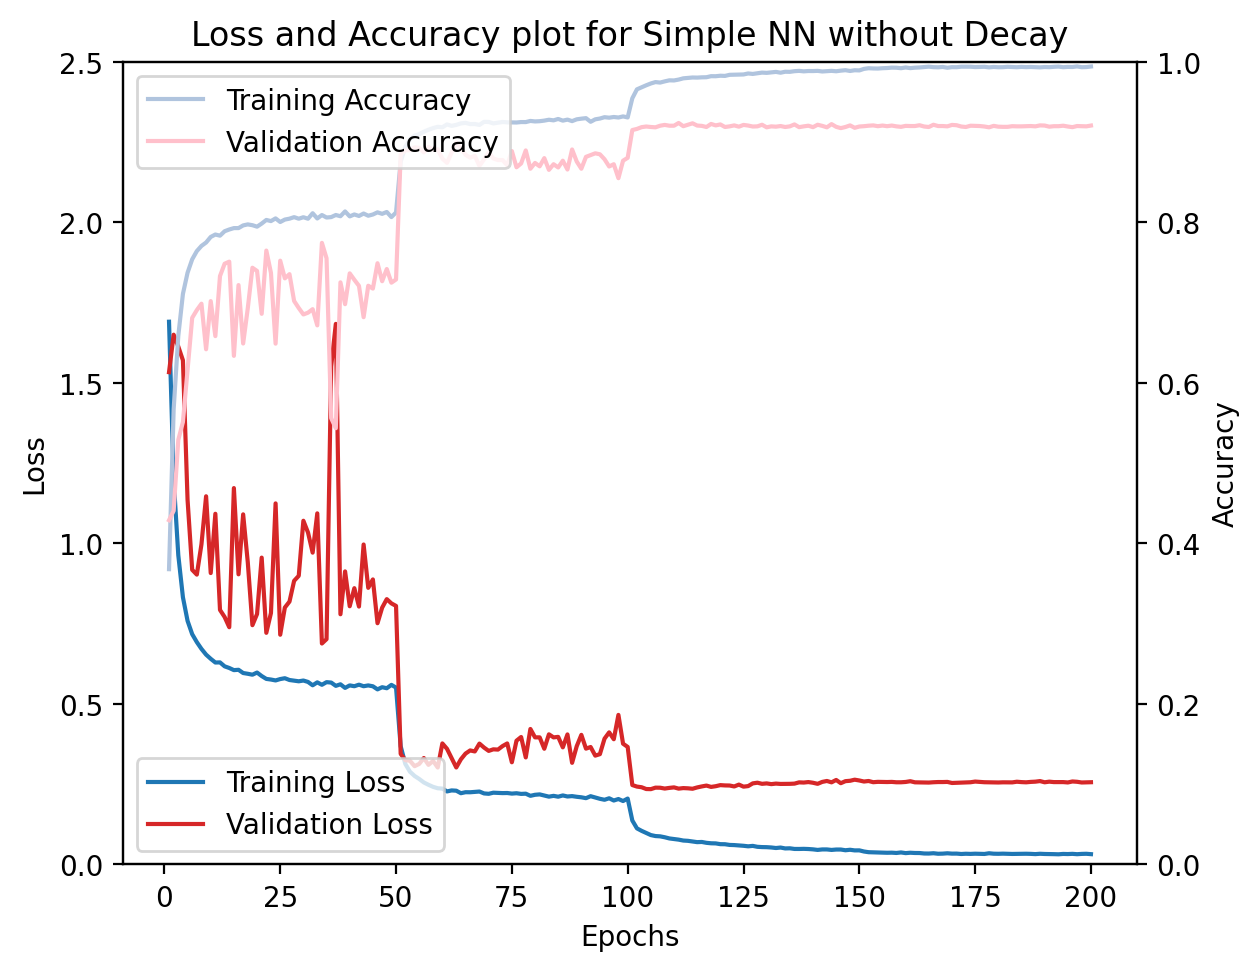

In [16]:
plot_results(
    resnet_train_loss,
    resnet_val_loss,
    resnet_train_acc,
    resnet_val_acc,
    title = "Loss and Accuracy plot for Simple NN without Decay",
    loss_lim=(0,2.5)
)